# **Predicting Use of Force Type from NOPD**

# **Introduction**

### **by Ulysses Zamora and Rajarshi Chatterjee**

**We will be looking at how different factors affect the Use of Force in various Different senerios. Each row in the dataset represents an entry on an incident in which NOPD was involded along with either one or multiple suspects . Our Ultimate goal will be to get a better understanding why was Force used in certain senarios and what are the common patterns . Using this we will also try to predict Use of Force Level given various factors .**

Dataset Statistics:

*   Date   : November 30
*   Time   : 11:30 am 
*   Source : https://catalog.data.gov/dataset/nopd-use-of-force-incidents

## **Mounting the Data from Google Drive**

### **Importing Various Packages we will work with**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import datetime 
import math  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

Mounted at /content/drive


# **Pre - Processing**

**Our Dataset had a lot of Columns that werent much use to us , this included Columns which contained Bad Data / No Data / Incomplete Data etc as well as columns which represent Index Values of some kind like File Numbers etc .**

In [ ]:
df = pd.read_csv("drive/My Drive/NOPD_Use_of_Force_Incidents.csv")
df = df.drop(['PIB File Number', 'Date Occurred', 'Originating Bureau', 'Division level', 'Division', 'Unit', 'Working Status', 'Shift', 'Investigation status',
              'Light Condition', 'Weather Condition', 'Officer Age', 'Distance Between', 'Officer Gender', 'Subject Age', 'Subject Height', 
              'Subject Arrest Charges', 'Subject Gender'], axis=1)

In [ ]:
rcParams['figure.figsize'] = 10,6
sns.set_context('notebook')

**Some Initial Data Exploration**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Disposition                  2658 non-null   object
 1   Service Type                 2662 non-null   object
 2   Use of Force Type            2666 non-null   object
 3   Use of Force Level           2666 non-null   object
 4   Subject Influencing Factors  2616 non-null   object
 5   Use of Force Effective       2666 non-null   object
 6   Officer Race/Ethnicity       2663 non-null   object
 7   Officer Years of Service     2663 non-null   object
 8   Subject Ethnicity            2631 non-null   object
 9   Subject Build                2552 non-null   object
 10  Subject Injured              2666 non-null   object
 11  Subject Hospitalized         2666 non-null   object
 12  Subject Arrested             2666 non-null   object
 13  Use of Force Reason          2662

**Fraction of NA Values in all remaining columns**

In [ ]:
df.isna().mean()

Disposition                    0.003001
Service Type                   0.001500
Use of Force Type              0.000000
Use of Force Level             0.000000
Subject Influencing Factors    0.018755
Use of Force Effective         0.000000
Officer Race/Ethnicity         0.001125
Officer Years of Service       0.001125
Subject Ethnicity              0.013128
Subject Build                  0.042761
Subject Injured                0.000000
Subject Hospitalized           0.000000
Subject Arrested               0.000000
Use of Force Reason            0.001500
Officer Injured                0.000000
dtype: float64

**In the next few code cells we are doing a few value ounts on various volumns to get a better feel for the columns**

In [ ]:
df['Disposition'].value_counts()

Use Of Force Authorized                             1256
UOF Justified                                       1117
Pending                                               88
UOF Justified With Training                           78
UOF Justified With Policy Violation                   55
UOF Not Justified                                     44
Use Of Force Not Authorized                            7
UOF Complaint of Injury/No Reportable Force Used       5
UOF No Reportable Force Used by Officer                4
uof                                                    1
Cancelled                                              1
Cancel FIT FTN                                         1
Pending | UOF Justified                                1
Name: Disposition, dtype: int64

In [ ]:
df['Service Type'].value_counts()

Call for Service                1140
Arresting                        835
Traffic Stop                     207
Pedestrian Stop                  186
Serving a Warrant                162
Other                            128
Call for Service | Arresting       2
Transport                          1
Not Used                           1
Name: Service Type, dtype: int64

In [ ]:
df['Use of Force Type'].value_counts()

Firearm (Exhibited)                                                                                                                                     597
Firearm (Exhibited) | Firearm (Exhibited)                                                                                                               239
Takedown (no injury)                                                                                                                                    122
CEW Exhibited/Laser                                                                                                                                     115
CEW Deployment                                                                                                                                          111
                                                                                                                                                       ... 
Force (Take Down) | Firearm (Exhibited) | Firearm (Exhibited) | 

In [ ]:
df['Subject Hospitalized'].value_counts()

No                                                                1417
Yes                                                                881
No | No                                                            178
No | No | No                                                        64
Yes | Yes                                                           54
No | No | No | No                                                   35
Yes | Yes | Yes                                                     13
No | No | No | No | No                                               8
Yes | Yes | Yes | Yes                                                4
Yes | Yes | Yes | Yes | Yes                                          4
Yes | Yes | Yes | Yes | Yes | Yes | Yes                              1
No | No | No | No | No | No | No | No | No | No | No | No | No       1
Yes | Yes | Yes | Yes | Yes | Yes                                    1
No | No | No | No | No | No | No | No                                1
Yes | 

# **Data Cleaning and Variable Setting**

**The Dataset had a lot of columns which had various Delimiters in them and we had segregate that data so we can get the useful information out , For the most part we simply split the various columns and merged them into one value , but for some we had to Split them into different columns and then merge them afterwards**

In [ ]:
df['Use of Force Type'] = df['Use of Force Type'].str.split('|')
df['Use of Force Level'] = df['Use of Force Level'].str.split('|')
for i in range(0, len(df['Use of Force Type'])):
  df['Use of Force Type'][i] = [x.strip() for x in df['Use of Force Type'][i]]
  df['Use of Force Level'][i] = [x.strip() for x in df['Use of Force Level'][i]]
  dic = dict(zip(df['Use of Force Level'][i], df['Use of Force Type'][i]))
  dic = sorted(dic.items())
  df['Use of Force Type'][i] = dic[-1][1]
  df['Use of Force Level'][i] = dic[-1][0]

In [ ]:
df['Subject Hospitalized'] = df['Subject Hospitalized'].str.split('|')
for i in range(0, len(df['Subject Hospitalized'])):
  df['Subject Hospitalized'][i] = [x.strip() for x in df['Subject Hospitalized'][i]]
  df['Subject Hospitalized'][i] = df['Subject Hospitalized'][i][0]

In [ ]:
df.dropna(subset=['Subject Influencing Factors'], inplace=True)
df['Subject Influencing Factors'] = df['Subject Influencing Factors'].str.split('|')
df.reset_index(drop=True, inplace=True)
for i in range(0, len(df['Subject Influencing Factors'])):
  df['Subject Influencing Factors'][i] = [x.strip() for x in df['Subject Influencing Factors'][i]]
  df['Subject Influencing Factors'][i] = df['Subject Influencing Factors'][i][0]

In [ ]:
df.dropna(subset=['Officer Years of Service'], inplace=True)
df['Officer Years of Service'] = df['Officer Years of Service'].str.split('|')
df.reset_index(drop=True, inplace=True)
for i in range(0, len(df['Officer Years of Service'])):
  df['Officer Years of Service'][i] = [x.strip() for x in df['Officer Years of Service'][i]]
  df['Officer Years of Service'][i] = [int(x) for x in df['Officer Years of Service'][i] if x is not ""]
  df['Officer Years of Service'][i] = math.ceil(np.mean(df['Officer Years of Service'][i]))

In [ ]:
df['Officer Race/Ethnicity'] = df['Officer Race/Ethnicity'].str.split('|')
for i in range(0, len(df['Officer Race/Ethnicity'])):
  df['Officer Race/Ethnicity'][i] = [x.strip() for x in df['Officer Race/Ethnicity'][i]]
  if len(np.unique(df['Officer Race/Ethnicity'][i])) > 1:
    df['Officer Race/Ethnicity'][i] = 'Multi-Ethnic'
  else:
    df['Officer Race/Ethnicity'][i] = df['Officer Race/Ethnicity'][i][0]

In [ ]:
df['Subject Ethnicity'].fillna('Black', inplace=True)
df['Subject Ethnicity'] = df['Subject Ethnicity'].str.split('|')
for i in range(0, len(df['Subject Ethnicity'])):
  df['Subject Ethnicity'][i] = [x.strip() for x in df['Subject Ethnicity'][i]]
  if len(np.unique(df['Subject Ethnicity'][i])) > 1:
    df['Subject Ethnicity'][i] = 'Multi-Ethnic'
  else:
    df['Subject Ethnicity'][i] = df['Subject Ethnicity'][i][0]

In [ ]:
df['Subject Build'].fillna('Medium', inplace=True)
df['Subject Build'] = df['Subject Build'].str.split('|')
for i in range(0, len(df['Subject Build'])):
  df['Subject Build'][i] = [x.strip() for x in df['Subject Build'][i]]
  df['Subject Build'][i] = np.unique(df['Subject Build'][i])[0]

In [ ]:
df['Subject Arrested'] = df['Subject Arrested'].str.split('|')
for i in range(0, len(df['Subject Arrested'])):
  df['Subject Arrested'][i] = [x.strip() for x in df['Subject Arrested'][i]]
  df['Subject Arrested'][i] = df['Subject Arrested'][i][0]

In [ ]:
df['Subject Injured'] = df['Subject Injured'].str.split('|')
for i in range(0, len(df['Subject Injured'])):
  df['Subject Injured'][i] = [x.strip() for x in df['Subject Injured'][i]]
  df['Subject Injured'][i] = df['Subject Injured'][i][0]


# **Data Visualization**

**Use of Force Level has various Degrees starting from L1 to L4**

**This Graph Shows Use of Force level used and if Subject was Hosiptalized or not**

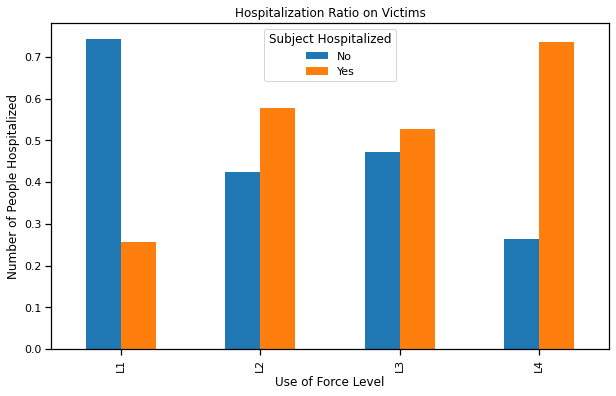

In [ ]:
pd.crosstab(df['Use of Force Level'], df['Subject Hospitalized'], normalize='index').plot.bar();
plt.title('Hospitalization Ratio on Victims');
plt.xlabel('Use of Force Level');
plt.ylabel('Number of People Hospitalized');

**As we can see , there is a big contrast between L1 and L4 , the majority of Victims who have had L4 used on them were Hospitalized.**

**The Next Graph is trying to find a Relation between Use of Force Level and Subject Build**

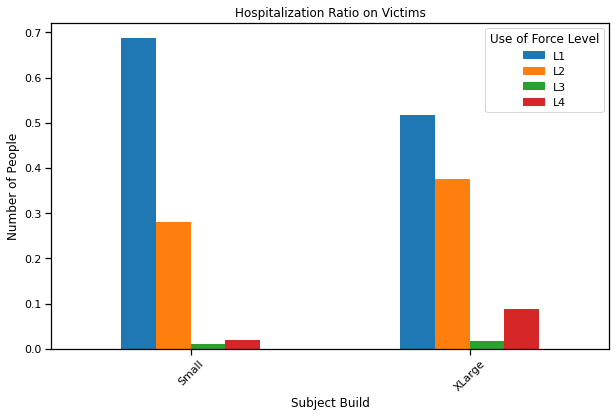

In [ ]:
x = df[((df['Subject Build'] == 'Small') | (df['Subject Build'] == 'XLarge'))]
pd.crosstab(x['Subject Build'], x['Use of Force Level'], normalize='index').plot.bar();
plt.title('Hospitalization Ratio on Victims');
plt.xlabel('Subject Build');
plt.ylabel('Number of People');
plt.xticks(rotation=45);

**As we can see there is indeed a big difference between the level of Force being used on Small vs XLarge People**
**There is a Substantial jump between use of L4 between small and Xlarge People**

**The Next Visualization shows us something which is unexpected
As General Arrest Stops increase so does the Use of Force but there is a Significant Dip after L3 which also tells us that the Authorities have a good idea of what to expect beforehand.**

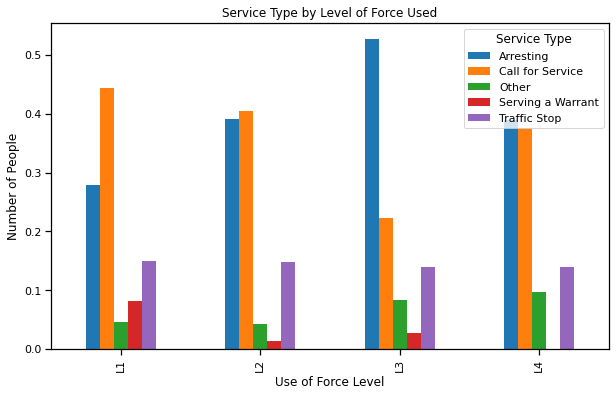

In [ ]:
df['Service Type'] = df['Service Type'].replace('Pedestrian Stop', 'Traffic Stop')
top_serv = df[(df['Service Type'] == 'Call for Service') | (df['Service Type'] == 'Arresting') | (df['Service Type'] == 'Traffic Stop') | 
              (df['Service Type'] == 'Serving a Warrant') | (df['Service Type'] == 'Other')]
pd.crosstab(top_serv['Use of Force Level'], top_serv['Service Type'], normalize='index').plot.bar();
plt.title('Service Type by Level of Force Used');
plt.xlabel('Use of Force Level');
plt.ylabel('Number of People');

**The Next Plot is kind of Intresting , as we will see if younger less experienced officers use more force than needed than more experienced officers who have been on the field longer .**

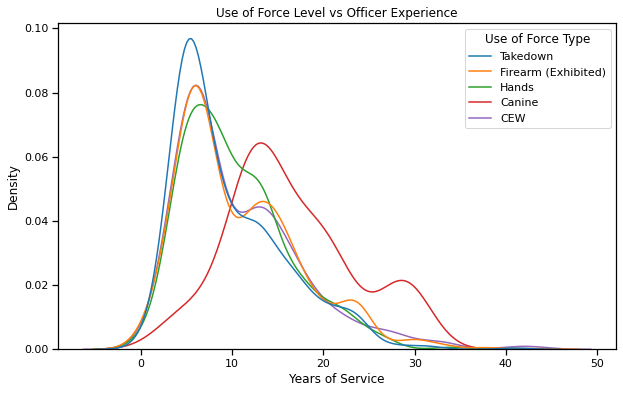

In [ ]:
df['Use of Force Type'] = df['Use of Force Type'].replace(['Takedown (no injury)', 'Force (Take Down)', 'Takedown (w/injury)'], 'Takedown')
df['Use of Force Type'] = df['Use of Force Type'].replace(['CEW Deployment', 'CEW Exhibited/Laser'], 'CEW')
df['Use of Force Type'] = df['Use of Force Type'].replace(['Canine (No Bite)', 'Canine (Bite)', 'Canine (Contact)'], 'Canine')

top_serv_type = df[(df['Use of Force Type'] == 'Firearm (Exhibited)') | (df['Use of Force Type'] == 'Takedown') | (df['Use of Force Type'] == 'CEW') |
                   (df['Use of Force Type'] == 'Hands') | (df['Use of Force Type'] == 'Canine')]
sns.kdeplot(df['Officer Years of Service'], hue='Use of Force Type', data=top_serv_type, common_norm=False);
plt.title('Use of Force Level vs Officer Experience');
plt.xlabel('Years of Service');
plt.ylabel('Density');

**As seen in the graph there is no clear difference between them but what we do notice is that only more experienced officers are allowed to handle Canines.**

# **Machine Learning**


# **KNN classification**

**Predicting the level of force is our primary objective. Knn classification is the primary method of use. Since Knn classification has multiple hyperparameters that can be tuned, a 10 fold cross validation will be used to determine the best K.**

**df['Use of Force Level'] is the target and thus must be converted to integer values in order to be used.**

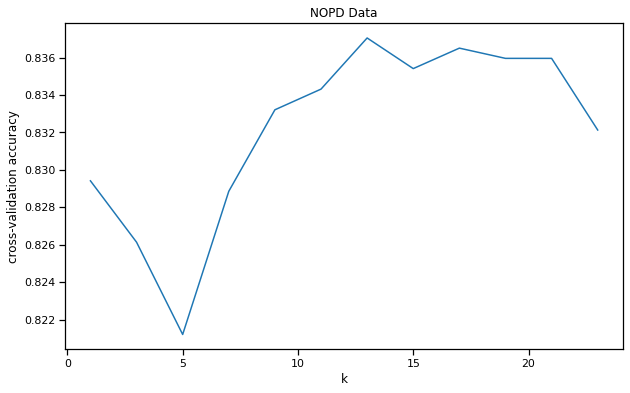

In [ ]:
df['Use of Force Level'].replace({'L1':1, 'L2':2, 'L3':3, 'L4':4}, inplace=True)

predictors = ['Use of Force Type', 'Subject Injured', 'Subject Ethnicity']
target = 'Use of Force Level'
X = pd.get_dummies(df[predictors],drop_first=True)
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

cv_accuracy = []
ks = np.arange(1,25,2)
for k in ks:
  clf = KNeighborsClassifier(n_neighbors=k, weights='distance')
  accs =  cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
  cv_accuracy.append(accs.mean())

plt.plot(ks, cv_accuracy)
plt.title('NOPD Data')
plt.xlabel('k')
plt.ylabel('cross-validation accuracy');


## **Result**

**By looking at the graph made from the 10 fold cross validation, one can see that the best k value is a decent size around 12 or 13, and then accuracy slowly decreases as the K value gets bigger. There are still more parameters to tune in order to ensure that the best model is being run such as the weight and the distance model. So, a cross validation grid search will be run in order to determine the best values.**

In [ ]:
grid = [ {'n_neighbors':range(3,22,2), 'weights':['uniform','distance'], 'p':[1,2]} ]
knnCV = GridSearchCV(KNeighborsClassifier(), grid, cv=10, scoring='accuracy')

knnCV.fit(X_train, y_train)
print(knnCV.best_params_)

{'n_neighbors': 13, 'p': 2, 'weights': 'distance'}


## **Result**

**After running the grid search, it replicates what the cross validation graph said by indicating that the best K neighbor was 13 while also finding out that distance was the best weight to use and euclidean distance was the best distance function to use for the best results. After finding the best values we computed our baseline accuracy and our test accuracy to see how our model performed.**

In [ ]:
clf = KNeighborsClassifier(n_neighbors=13, weights='distance', p=2)
clf.fit(X_train, y_train);
baseline_accuracy = (y_test == 1).mean()
print(f'Baseline Accuracy: {baseline_accuracy}')
print(f'Test Accuracy: {knnCV.best_score_}')

Baseline Accuracy: 0.6938775510204082
Test Accuracy: 0.8370473788506576


### **Result** 

**A new classifier object was created and trained with the values previously gotten. The baseline accuracy was computed by computing the fraction of test values that are 1 because it is the most occuring value in the test set compared to the others. The results showed that our model performed fairly well yielding us a higher value than the baseline accuracy.**


# **Decision Trees**

**Repeating the same process as KNN Classification, instead with decision trees. To start, a cross validation grid search will also be used in order to determine the best possible parameters for our decision tree model.**

In [ ]:
predictors = ['Use of Force Type', 'Subject Injured', 'Subject Ethnicity', 'Officer Race/Ethnicity']
target = 'Use of Force Level'

X = pd.get_dummies(df[predictors],drop_first=True)
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

grid = [ {'min_samples_split':range(2,5), 'max_depth': range(2,10),'criterion' : ['gini', 'entropy']} ]
treeCV = GridSearchCV(DecisionTreeClassifier(), grid, cv=10, scoring='accuracy')

treeCV.fit(X_train, y_train)
print(treeCV.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 2}


## **Result**

**After running the grid search, it showed that a max depth of 12, a minimum sample split of 2 and gini as the criterion, were the best possible parameters for our object. Since, decision tree supports selecting the best features for decisions, we ran that to see what the best features would be.**

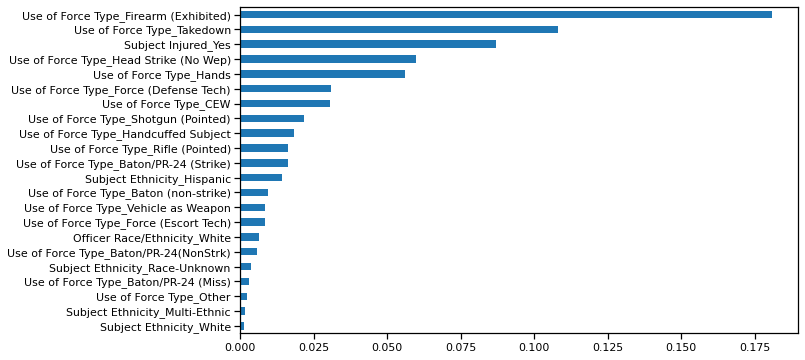

In [ ]:
selector = SelectKBest(mutual_info_classif, k=10)
selector.fit(X_train, y_train)
ser = pd.Series(selector.scores_, index=X.columns).sort_values()
ser = ser[ser > 0]
ser.plot.barh();

# **Result**

**The resulting graph shows the most important predictors that would be used in order to predict our target variable, note that we filtered out values with a score value of 0 because they have no importance. Now we will modify our original predictors to only use the values that were listed in this graph and train our new model with all the information we have learned including our hyperparameters and make a learning curve, to see if there is any bias or variance**.

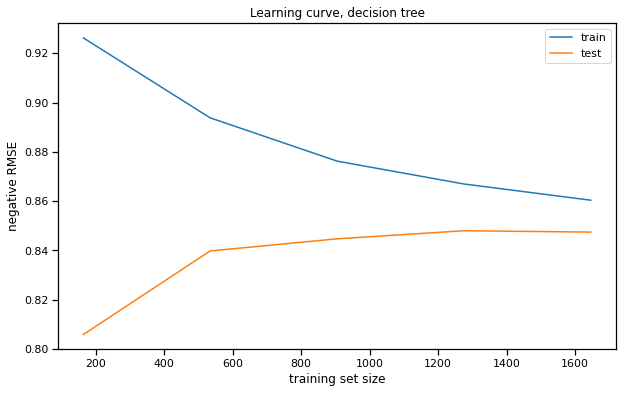

In [ ]:
X[ser.index].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
clf = DecisionTreeClassifier(max_depth=12, min_samples_split=2, criterion='gini', random_state=0)

train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='train');
plt.plot(train_sizes, test_scores_mean, label='test');
plt.xlabel('training set size');
plt.ylabel('negative RMSE');
plt.title('Learning curve, decision tree');
plt.legend();

# **Result** 

**The resulting learning curve was good. It did not appear to suffer from a lot of bias or variance because the gap starts off large then slowly converges to an end point. Now that we observed that our model did not suffer from variance or bias, we re-trained the model one final time to see our accuracy and see how it differed from our Knn classification model.**

In [ ]:
X[ser.index].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
clf = DecisionTreeClassifier(max_depth=12, min_samples_split=2, criterion='gini', random_state=0)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(f'Test Accuracy: {clf.score(X_test, y_test)}')

Test Accuracy: 0.8405612244897959


# **Result**

**After finishing the model again and computing the test accuracy we could see that the decision tree was more accurate, but only by a small amount. The decision tree had an accuracy value of around .84 while the Knn classification had an accuracy rating of about .83, showing that both models are fairly accurate and good at predicting the results.**

# **Conclusion**

**To sum up things , in this Report we looked at  Use of Force data from NOPD and various datapoints associated with it and how it affected various other variables , we found some intresting stuff along the way like the difference in force used depending on Subject Body Size .When we stated working with the dataset we faced a big issue as some of the most important columns had multiple values in them separated with delimiters and we struggled to figure out how not only how to separate them but then combine them back in a meaningful way without ruining the dataset, in the end we did successfully separate them but it was a challenge none the less . Although the main objective of the project was to train a fairly accuracy machine learning model , we did two separate machine learning models mainly to compare the test accuracys between them , both turned out around .84 which is fairly accurate. In Conclusion it shows us that not all variables are affected that much from Use of Force and at the same time some variables which we dont expect do get affected .**


